# Example usage for clustering in "movekit"

In [1]:
import movekit as mkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, convex_hull_plot_2d, delaunay_plot_2d
import networkx as nx

/home/luke/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in CSV file and preprocess

In [2]:
# Enter path to CSV file
path = "./datasets/fish-5.csv"

In [3]:
# Read in CSV file and preprocess
data = mkit.read_data(path)
preprocessed_data = mkit.preprocess(data)

Total number of missing values =  0
y            0
x            0
animal_id    0
time         0
dtype: int64


In [13]:
# converting positional data into scale, defined by user
mkit.convert_measueres(preprocessed_data, x_min = 0, x_max = 100, y_min = 0, y_max = 100).head()

,time,animal_id,x,y
0,1,312,49.663862,84.937627
1,1,511,44.688738,87.375033
2,1,607,47.555424,82.312218
3,1,811,55.281665,83.650358
4,1,905,44.134850,92.457755


### Detecting outliers
Function performs detection of outliers, based on user's criteria, regarding features, method and share of outliers.

In [4]:
# Extracting features for later use
feats = mkit.extract_features(preprocessed_data, fps = 3)

In [7]:
outs = mkit.outlier_detection(feats)

# printing all rows where outliers are present
outs[outs.loc[:,"outlier"] == 1]

,time,animal_id,outlier,x,y,distance,average_speed,average_acceleration,direction,stopped
1876,877,511,1,64.024072,7.887287,0.645740,0.645586,0.012156,-1.570202,0
1989,990,511,1,84.668724,35.864372,0.989962,0.974461,-0.011696,85.181662,0
1990,991,511,1,84.777247,36.784482,0.926487,0.934912,-0.039548,83.273314,0
1991,992,511,1,84.925232,37.660356,0.888287,0.895494,-0.039419,80.410027,0


In [8]:
# same function, different parameters
other_outs = mkit.outlier_detection(dataset = feats, features = ["average_speed", "average_acceleration"], contamination = 0.05, n_neighbors = 8, method = "median", metric = "euclidean")

# printing all rows where outliers are present
other_outs[other_outs.loc[:,"outlier"] == 1].head()

,time,animal_id,outlier,x,y,distance,average_speed,average_acceleration,direction,stopped
697,698,312,1,14.463095,47.140140,0.724021,0.722229,0.043150,-71.265096,0
698,699,312,1,14.718194,46.414669,0.769015,0.773842,0.051613,-70.626723,0
699,700,312,1,15.001480,45.636114,0.828491,0.819444,0.045602,-70.005491,0
700,701,312,1,15.300269,44.828807,0.860826,0.849685,0.030241,-69.690192,0
701,702,312,1,15.601877,44.023711,0.859737,0.850136,0.000452,-69.462855,0


### Group-level Analysis

Below we perform Analysis on Group-Level. This consists of:
- Group-Level averages,
- Centroid Medoid computation
- A dynamic time warping matrix, 
- A clustering over time based on absolute features,
- The centroid direction,
- The heading difference of each animal with respect to the current centroid
- The group - polarization for each timestep. 

#### Obtain group-level records for each point in time
Records consist of total group-distance, mean-speed mean-acceleration and mean distance from centroid. If input doesn't contain centroid or feature data, it is calculated, showing a warning.
Parameter object_output produces a post gis - compatible point.

In [4]:
mkit.group_movement(data).head()

/home/luke/.local/lib/python3.8/site-packages/movekit/feature_extraction.py:260: UserWarning: Recalculating features, since distance, speed or acceleration not found in input.
  warnings.warn('Recalculating features, since distance, speed or acceleration not found in input.')
/home/luke/.local/lib/python3.8/site-packages/movekit/feature_extraction.py:265: UserWarning: Recalculating centroid-distances, since not found in input dataset!
  warnings.warn('Recalculating centroid-distances, since not found in input dataset!')


,total_dist,mean_speed,mean_acceleration,mean_distance_centroid
time,,,,
1,0.000000,0.157979,-0.000339,29.4616
2,1.174908,0.157641,-0.000339,29.5850
3,1.025155,0.155610,-0.000339,29.6914
4,0.918960,0.153579,-0.000339,29.7782
5,0.830461,0.153341,-0.000339,29.8518


#### Obtain centroid, medoid and distance to centroid 
Parameter options go either for each unit per timestamp or as post-gis compatible object

In [10]:
movement = mkit.centroid_medoid_computation(data, object_output = False)

In [11]:
movement.head()

,time,animal_id,x,y,x_centroid,y_centroid,medoid,distance_to_centroid
0,1,312,49.663862,84.937627,48.265,86.147,312,1.849
1,2,312,49.666681,84.851367,48.267,86.145,312,1.906
2,3,312,49.666681,84.785013,48.269,86.148,312,1.952
3,4,312,49.665271,84.738565,48.269,86.157,312,1.990
4,5,312,49.663862,84.705388,48.269,86.168,312,2.021


#### Obtain a matrix, based on dynamic time warping
Each Animal-ID is displayed in the indices, the entries reflect the euclidean distances of the animal's trajectories.

In [12]:
mkit.dtw_matrix(preprocessed_data)

,312,511,607,811,905
312,0.000000,5559.971244,5873.940640,8235.343344,7221.072340
511,5559.971244,0.000000,5119.824950,8667.471335,4258.767686
607,5874.377835,5119.822061,0.000000,7491.758830,7215.670756
811,8235.343344,8667.471335,7491.758830,0.000000,6826.692241
905,7221.068698,4258.767686,7215.670756,6826.692241,0.000000


#### Time series clustering for absolute features
Function can also be executed without extracted features, performing a standard feature-extraction before.

In [13]:
feats = mkit.extract_features(preprocessed_data)

In [138]:
mkit.ts_cluster(feats, 2).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,cluster,ClustCenter,centroid_distance,centroid_average_speed,centroid_average_acceleration,centroid_direction,centroid_stopped
0,1,312,405.29,417.76,0.000000,0.195256,0.034915,0.000000,1,0,"[0.0, 0.1368634550909732, 0.03308990889422565,...",0.000000,0.136863,0.033090,0.000000,1.00
1,2,312,405.31,417.37,0.390512,0.230171,0.034915,-87.064327,1,0,"[0.2737269101819464, 0.16995336398519884, 0.03...",0.273727,0.169953,0.033090,50.122305,1.00
2,3,312,405.31,417.07,0.300000,0.300250,0.070079,-90.000000,1,0,"[0.23613318177365017, 0.23819999950407833, 0.0...",0.236133,0.238200,0.068247,57.588956,1.00
3,4,312,405.30,416.86,0.210238,0.220190,-0.080060,-92.726311,1,0,"[0.2047399065566385, 0.20861663269832095, -0.0...",0.204740,0.208617,-0.029583,58.395905,1.00
4,5,312,405.29,416.71,0.150333,0.154184,-0.066007,-93.814075,1,0,"[0.18497680976467415, 0.18655020902436156, -0....",0.184977,0.186550,-0.022066,82.405218,1.00
5,6,312,405.27,416.61,0.101980,0.107438,-0.046746,-101.309932,1,0,"[0.16993391075177205, 0.17056468640956685, -0....",0.169934,0.170565,-0.015986,7.468998,1.00
6,7,312,405.27,416.54,0.070000,0.073993,-0.033444,-90.000000,1,0,"[0.1567833387122543, 0.1594254481518162, -0.01...",0.156783,0.159425,-0.011139,12.349676,1.00
7,8,312,405.27,416.49,0.050000,0.082164,0.008170,-90.000000,1,0,"[0.1515590949914222, 0.16352576946216527, 0.00...",0.151559,0.163526,0.004100,20.271268,0.75
8,9,312,405.31,416.37,0.126491,0.099519,0.017355,-71.565051,1,0,"[0.18223487468281913, 0.17649594959864545, 0.0...",0.182235,0.176496,0.012970,20.216203,0.75
9,10,312,405.38,416.27,0.122066,0.136601,0.037082,-55.007980,1,0,"[0.19569387912169495, 0.20129153466861233, 0.0...",0.195694,0.201292,0.024796,26.642574,0.75


#### Get the centroid direction
If no centroid coordinates are found in input, function calculates centroids first, emitting a warning.

In [15]:
mkit.compute_centroid_direction(data).sort_values(['time','animal_id']).head(10)

/home/luke/.local/lib/python3.8/site-packages/movekit/clustering.py:169: UserWarning: x_centroid or y_centroid not found in data. Calculating centroid...
  warnings.warn('x_centroid or y_centroid not found in data. Calculating centroid...')


,time,animal_id,x,y,x_centroid,y_centroid,centroid_direction
0,1,312,49.663862,84.937627,48.265,86.147,NaN
1000,1,511,44.688738,87.375033,48.265,86.147,NaN
2000,1,607,47.555424,82.312218,48.265,86.147,NaN
3000,1,811,55.281665,83.650358,48.265,86.147,NaN
4000,1,905,44.134850,92.457755,48.265,86.147,NaN
1,2,312,49.666681,84.851367,48.267,86.145,-45.0
1001,2,511,44.691556,87.383880,48.267,86.145,-45.0
2001,2,607,47.544149,82.312218,48.267,86.145,-45.0
3001,2,811,55.328175,83.721136,48.267,86.145,-45.0
4001,2,905,44.106662,92.457755,48.267,86.145,-45.0


#### Getting the heading difference
Calculate the difference in degrees between the animal's direction and the centroid's direction for each timestep. Stronger gain in y gives positive difference, weaker gain in y gives negative difference, since constant y is defined to be 0 degrees.

In [16]:
mkit.get_heading_difference(feats).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,x_centroid,y_centroid,medoid,distance_to_centroid,centroid_direction,heading_difference
0,1,312,49.663862,84.937627,0.000000,0.046467,-0.004028,0.000000,1,48.265,86.147,312,1.849,NaN,NaN
1,2,312,49.666681,84.851367,0.086306,0.042439,-0.004028,-88.128385,1,48.267,86.145,312,1.906,-45.000000,-43.128385
2,3,312,49.666681,84.785013,0.066354,0.038588,-0.004028,-90.000000,1,48.269,86.148,312,1.952,56.309932,-146.309932
3,4,312,49.665271,84.738565,0.046469,0.035147,-0.004028,-91.738013,1,48.269,86.157,312,1.990,90.000000,178.261987
4,5,312,49.663862,84.705388,0.033207,0.034257,-0.004028,-92.432502,1,48.269,86.168,312,2.021,90.000000,177.567498
5,6,312,49.661043,84.683270,0.022297,0.033253,-0.004028,-97.262745,1,48.268,86.182,312,2.046,94.085617,168.651639
6,7,312,49.661043,84.667787,0.015483,0.036548,-0.003851,-90.000000,1,48.268,86.200,312,2.071,90.000000,-180.000000
7,8,312,49.661043,84.656728,0.011059,0.032483,-0.003441,-90.000000,1,48.267,86.220,312,2.095,92.862405,177.137595
8,9,312,49.666681,84.630187,0.027134,0.028208,-0.000890,-78.008390,1,48.268,86.241,312,2.133,87.273689,-165.282079
9,10,312,49.676546,84.608069,0.024219,0.026307,-0.001004,-65.960864,1,48.270,86.262,312,2.171,84.559668,-150.520532


#### Computing polarization
Computing polarization of animals for each timestep. Value is between 0 and 1

In [17]:
mkit.compute_polarization(feats).head()


,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,polarization
0,1,312,49.663862,84.937627,0.000000,0.046467,-0.004028,0.000000,1,1.000000
1,2,312,49.666681,84.851367,0.086306,0.042439,-0.004028,-88.128385,1,0.341888
2,3,312,49.666681,84.785013,0.066354,0.038588,-0.004028,-90.000000,1,0.148168
3,4,312,49.665271,84.738565,0.046469,0.035147,-0.004028,-91.738013,1,0.627110
4,5,312,49.663862,84.705388,0.033207,0.034257,-0.004028,-92.432502,1,0.384606


### Spatial Objects
The function below produces three types of spatial objects: Voronoi-Diagrams, Convex Hulls and Delaunay Triangles. Optionally, one may obtain only group-specific outputs - one object per time-capture. These spatial objects may be used for a set of attributes, which are described below in detail.
To get the full functionality of all attributes, please go to https://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/spatial.html.

In [8]:
spatial_obj = mkit.get_spatial_objects(preprocessed_data, group_output = True)
spatial_obj.head()

,time,convex_hull_object,voronoi_object,delaunay_object,convex_hull_volume,voronoi_volume
0,1,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f26c...,<scipy.spatial.qhull.Delaunay object at 0x7f26...,1519.44120,inf
1,2,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f26c...,<scipy.spatial.qhull.Delaunay object at 0x7f26...,1528.95525,inf
2,3,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f26c...,<scipy.spatial.qhull.Delaunay object at 0x7f26...,1539.23800,inf
3,4,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f26c...,<scipy.spatial.qhull.Delaunay object at 0x7f26...,1549.61380,inf
4,5,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f26c...,<scipy.spatial.qhull.Delaunay object at 0x7f26...,1560.33905,inf


In [9]:
sing_spatial_obj = mkit.get_spatial_objects(preprocessed_data, group_output = False)

In [7]:
sing_spatial_obj.head()

,time,animal_id,x,y,convex_hull_object,voronoi_object,delaunay_object,convex_hull_volume,voronoi_volume
0,1,312,405.29,417.76,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f834...,<scipy.spatial.qhull.Delaunay object at 0x7f83...,1519.44120,2414.225693
1,2,312,405.31,417.37,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f834...,<scipy.spatial.qhull.Delaunay object at 0x7f83...,1528.95525,2389.875725
2,3,312,405.31,417.07,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f834...,<scipy.spatial.qhull.Delaunay object at 0x7f83...,1539.23800,2372.018571
3,4,312,405.30,416.86,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f834...,<scipy.spatial.qhull.Delaunay object at 0x7f83...,1549.61380,2360.489279
4,5,312,405.29,416.71,<scipy.spatial.qhull.ConvexHull object at 0x7f...,<scipy.spatial.qhull.Voronoi object at 0x7f834...,<scipy.spatial.qhull.Delaunay object at 0x7f83...,1560.33905,2350.628662


### Obtaining a list of graphs, based on delaunay triangulations
Each timestep carries the respective graph with data attached to nodes, edges and graph. Just insert time and animal specific x and y coordinate data.

In [27]:
graph_list = mkit.network_time_graphlist(preprocessed_data)

/home/luke/.local/lib/python3.8/site-packages/movekit/clustering.py:238: UserWarning: calculating direction, since not found in input!
  warnings.warn('calculating direction, since not found in input!')
/home/luke/.local/lib/python3.8/site-packages/movekit/feature_extraction.py:284: UserWarning: Recalculating features, since distance, speed or acceleration not found in input.
  warnings.warn('Recalculating features, since distance, speed or acceleration not found in input.')
/home/luke/.local/lib/python3.8/site-packages/movekit/feature_extraction.py:289: UserWarning: Recalculating centroid-distances, since not found in input dataset!
  warnings.warn('Recalculating centroid-distances, since not found in input dataset!')


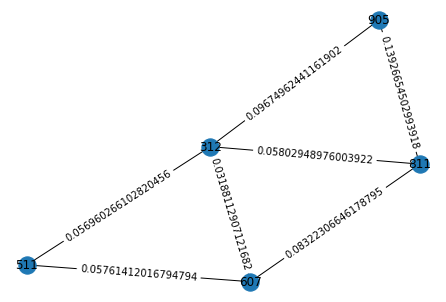

In [28]:
# Visualizing the graph for time step '10'-

labels = nx.get_node_attributes(graph_list[9], 'animal_id')

pos = nx.spring_layout(graph_list[9])


nx.draw(graph_list[9], pos)
node_labels = nx.get_node_attributes(graph_list[9], 'animal_id')
nx.draw_networkx_labels(graph_list[9], pos=pos, labels=node_labels)

edge_labels = nx.get_edge_attributes(graph_list[9], 'distance')
nx.draw_networkx_edge_labels(graph_list[9], pos=pos, edge_labels=edge_labels)
plt.show()

In [31]:
# Display all graph attributes at time 9
graph_list[9].graph

{'time': 10,
 'x_centroid': 395.398,
 'y_centroid': 423.748,
 'medoid': 312,
 'polarization': 0.1541444103387526,
 'total_dist': 0.8498575558117887,
 'mean_speed': 0.17356829246299718,
 'mean_acceleration': 0.0016630029803382795,
 'mean_distance_centroid': 29.9754,
 'centroid_direction': 83.92754359276314}

In [32]:
# Display all edges at time 9
graph_list[9].edges

EdgeView([(312, 811), (312, 607), (312, 511), (312, 905), (811, 905), (811, 607), (607, 511)])

In [33]:
# Display the distance of one node pair at time 9
graph_list[9].edges[312, 811]

{'distance': 0.05802948976003922}

In [30]:
# Display all attributes of node 312 at time 9
graph_list[9].nodes[312]

{'time': 10,
 'animal_id': 312,
 'x': 405.38,
 'y': 416.27,
 'distance': 0.12206555615735173,
 'average_speed': 0.12548009844845703,
 'average_acceleration': -0.0033440544361974522,
 'direction': -55.007979801450084,
 'stopped': 1,
 'x_centroid': 395.398,
 'y_centroid': 423.748,
 'medoid': 312,
 'distance_to_centroid': 12.472}

#### Producing a voronoi diagram
Each timestep gets a voronoi object as well as the area of the voronoi - shape. Infinity, if respective animal is outmost in swarm.

Voronoi object contains the following attributes:

- `points` Coordinates of input points.

- `vertices` Coordinates of the Voronoi vertices.

- `ridge_points` Indices of the points between which each Voronoi ridge lies.

- `ridge_vertices` Indices of the Voronoi vertices forming each Voronoi ridge.

- `regions` Indices of the Voronoi vertices forming each Voronoi region. -1 indicates vertex outside the Voronoi diagram.

- `point_region` Index of the Voronoi region for each input point. If qhull option “Qc” was not specified, the list will contain -1 for points that are not associated with a Voronoi region.

- `furthest_site` True if this was a furthest site triangulation and False if not.



#### Producing a convex hull
Similar to voronoi-diagram, also the convex hull is of interest for movement-related data. Additionally, a set of attributes may be attached to the convex hull objects. Examples are:

- `points` (array of ints) Coordinates of input points

- `vertices` (array of ints ) Point indices forming the veritces of the convex hull

- `area` Area of the convex hull.

- `volume` Volume of the convex hull.

#### Producing Delaunay-triangles
Examples for attributes of interest consist of:

- `transform`	Affine transform from x to the barycentric coordinates c.
- `vertex_to_simplex`	Lookup array, from a vertex, to some simplex which it is a part of.
- `convex_hull`	Vertices of facets forming the convex hull of the point set.
- `vertex_neighbor_vertices`	Neighboring vertices of vertices.
- `points`	(ndarray of double, shape (npoints, ndim)) Coordinates of input points.
- `simplices`	(ndarray of ints, shape (nsimplex, ndim+1)) Indices of the points forming the simplices in the triangulation. For 2-D, the points are oriented counterclockwise.
- `neighbors`	(ndarray of ints, shape (nsimplex, ndim+1)) Indices of neighbor simplices for each simplex. The kth neighbor is opposite to the kth vertex. For simplices at the boundary, -1 denotes no neighbor. 

#### Plotting all spatial objects at the 3rd timestep. 

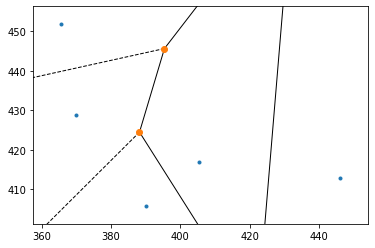

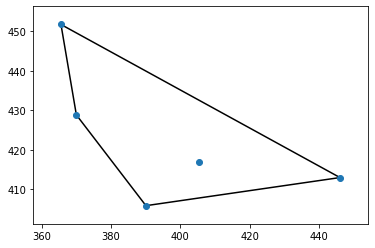

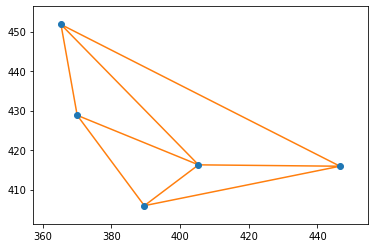

In [28]:
# Plot all scipy - spatial objects of a given timestamp
voronoi_plot_2d(spatial_obj.voronoi_object[3])
convex_hull_plot_2d(spatial_obj.convex_hull_object[3])
delaunay_plot_2d(spatial_obj.delaunay_object[9])
plt.show()